In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import torch

# CUDA(GPU) 사용 가능 여부 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

GPU is available


In [ ]:
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import random

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import os

train_data_path = '/content/drive/MyDrive/Capstone_Project/DCASE_challenge/fan/train'
test_data_path = '/content/drive/MyDrive/Capstone_Project/DCASE_challenge/fan/train'
machine_ids = ['machine_id_00', 'machine_id_02', 'machine_id_04', 'machine_id_06']

# 훈련 데이터와 테스트 데이터 파일 경로 수집
for machine_id in machine_ids:
    # 훈련 데이터 경로
    train_dir = os.path.join(train_data_path, machine_id, 'train')
    train_files = [os.path.join(train_dir, file) for file in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, file))]

    # 테스트 데이터 경로
    test_dir = os.path.join(test_data_path, machine_id, 'test')
    test_files = [os.path.join(test_dir, file) for file in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, file))]

    # 이후 데이터 처리...


In [ ]:
import os

train_data_path = '/content/drive/MyDrive/Capstone_Project/DCASE_challenge/fan/train'
machine_ids = ['machine_id_00', 'machine_id_02', 'machine_id_04', 'machine_id_06']

for machine_id in machine_ids:
    train_dir = os.path.join(train_data_path, machine_id, 'train')

    if not os.path.exists(train_dir):
        print(f"디렉토리가 존재하지 않습니다: {train_dir}")
        continue

    train_files = [os.path.join(train_dir, file) for file in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, file))]


In [ ]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, min_val=None, max_val=None, alpha=1.0):
        self.file_paths = file_paths
        self.min_val = min_val
        self.max_val = max_val
        self.alpha = alpha

        # min_val과 max_val이 제공되지 않았을 경우, 전체 데이터셋에서 계산하도록 구현할 수 있습니다.
        if self.min_val is None or self.max_val is None:
            self.min_val, self.max_val = self.calculate_min_max_values()

    def __len__(self):
        return len(self.file_paths)

    def calculate_min_max_values(self):
        # 스펙트로그램의 최소값과 최대값을 계산합니다.
        all_values = []
        for file_path in self.file_paths:
            y, sr = librosa.load(file_path, sr=None)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            log_S = librosa.power_to_db(S, ref=np.max)
            all_values.append(log_S.flatten())

        all_values = np.concatenate(all_values)
        min_val = all_values.min()
        max_val = all_values.max()
        return min_val, max_val

    def __getitem__(self, idx):
      # 첫 번째 오디오 파일 로드 및 처리
      file_path1 = self.file_paths[idx]
      x1 = self.process_file(file_path1)

      # 두 번째 오디오 파일 로드 및 처리 (데이터 증강을 위한 mixup)
      file_path2 = np.random.choice(self.file_paths)
      x2 = self.process_file(file_path2)

      # mixup 파라미터 생성
      lam = np.random.beta(self.alpha, self.alpha) if self.alpha > 0 else 1

      # 두 오디오 파일의 스펙트로그램을 섞음
      mixed_x = lam * x1 + (1 - lam) * x2
      return mixed_x


    def process_file(self, file_path):
        # 오디오 파일 로드 및 스펙트로그램 생성
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)

        # 정규화
        normalized_log_S = (log_S - self.min_val) / (self.max_val - self.min_val)

        # PyTorch Tensor로 변환
        normalized_log_S_tensor = torch.tensor(normalized_log_S, dtype=torch.float32)
        return normalized_log_S_tensor


In [ ]:


# 조기 종료
class EarlyStopping:
    def __init__(self, patience=15, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [ ]:
import os
from sklearn.model_selection import train_test_split

# 각 machine_id별로 처리
for machine_id in machine_ids:
    train_dir = os.path.join(train_data_path, machine_id, 'train')

    # 해당 machine_id의 train 디렉토리 존재 여부 확인
    if not os.path.exists(train_dir):
        print(f"경고: '{train_dir}' 디렉토리가 존재하지 않습니다.")
        continue

    # 해당 machine_id의 train 파일 경로 수집
    try:
        train_files = [os.path.join(train_dir, file) for file in os.listdir(train_dir)]
    except FileNotFoundError:
        print(f"경고: '{train_dir}'에서 파일을 찾을 수 없습니다.")
        continue

    # 해당 machine_id의 train 데이터셋에서 min_val과 max_val 계산
    temp_dataset = AudioDataset(train_files)
    min_val, max_val = temp_dataset.calculate_min_max_values()

    # 데이터셋 분할
    train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=2023)

    # 데이터셋 인스턴스 생성
    train_dataset = AudioDataset(train_files, min_val, max_val)
    val_dataset = AudioDataset(val_files, min_val, max_val)

    # DataLoader 인스턴스 생성
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(Autoencoder, self).__init__()
        # 인코더
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_prob)
        )

        # 디코더
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        target_height, target_width = 128, 313  # 예상되는 목표 크기
        x = F.interpolate(x, size=(target_height, target_width), mode='bilinear', align_corners=False)


        return x


In [ ]:
# import os
# from sklearn.model_selection import train_test_split

# # 각 machine_id별로 처리
# for machine_id in machine_ids:
#     # 해당 machine_id의 train 파일 경로 수집
#     train_files = [os.path.join(train_data_path, machine_id, 'train', file)
#                    for file in os.listdir(os.path.join(train_data_path, machine_id, 'train'))]

#     # 해당 machine_id의 train 데이터셋에서 min_val과 max_val 계산
#     temp_dataset = AudioDataset(train_files)
#     min_val, max_val = temp_dataset.calculate_min_max_values()

#     # 데이터셋 분할
#     train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=2023)

#     # 데이터셋 인스턴스 생성
#     train_dataset = AudioDataset(train_files, min_val, max_val)
#     val_dataset = AudioDataset(val_files, min_val, max_val)

#     # DataLoader 인스턴스 생성
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#     # 여기서 모델 트레이닝 및 검증 로직 추가


In [ ]:
from tqdm import tqdm

# 모델 훈련 함수
def train_model(model, train_loader, val_loader, machine_id, n_epochs=50):
    early_stopping = EarlyStopping(patience=7, verbose=True)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for mixed_x in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            mixed_x = mixed_x.unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(mixed_x)
            loss = criterion(outputs, mixed_x)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
          for mixed_x in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
              mixed_x = mixed_x.unsqueeze(1).to(device)
              outputs = model(mixed_x)
              loss = criterion(outputs, mixed_x)
              val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1} Train loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}')

         # 모델 저장 디렉토리 정의
        model_save_dir = '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan'  # 모델을 저장할 경로

        # 조기 종료 체크
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


        # 모델 파라미터 저장
        model_save_path = f'{model_save_dir}/model_{machine_id}.pt'
        torch.save(model.state_dict(), model_save_path)
        model_save_dir = '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/results'  # 구글 드라이브 내의 저장 경로로 변경
        models[f'{machine_id}'] = model_save_path

        if early_stopping.early_stop:
            print("Initializing a new model for the next fold")
            model = Autoencoder().to(device)  # 새 모델 초기화


    # 손실 그래프 그리기
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.title(f'Machine ID {machine_id} Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # 검증 손실의 평균과 표준편차 계산
    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    print(f'Validation Loss for Machine ID {machine_id}: Mean - {val_loss_mean}, Standard Deviation - {val_loss_std}')
    return model, val_loss_mean, val_loss_std



Starting training for Machine ID machine_id_00


Epoch 1 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 1 Train loss: 0.0172, Val loss: 0.0141
Validation loss decreased (inf --> 0.014101).  Saving model ...


Epoch 2 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Epoch 2 Train loss: 0.0068, Val loss: 0.0157
EarlyStopping counter: 1 out of 7


Epoch 3 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Epoch 3 Train loss: 0.0056, Val loss: 0.0048
Validation loss decreased (0.014101 --> 0.004836).  Saving model ...


Epoch 4 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 4 Train loss: 0.0047, Val loss: 0.0050
EarlyStopping counter: 1 out of 7


Epoch 5 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 5 Train loss: 0.0043, Val loss: 0.0041
Validation loss decreased (0.004836 --> 0.004060).  Saving model ...


Epoch 6 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 6 Train loss: 0.0040, Val loss: 0.0044
EarlyStopping counter: 1 out of 7


Epoch 7 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 7 Train loss: 0.0038, Val loss: 0.0379
EarlyStopping counter: 2 out of 7


Epoch 8 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch 8 Train loss: 0.0037, Val loss: 0.0037
Validation loss decreased (0.004060 --> 0.003679).  Saving model ...


Epoch 9 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 9 Train loss: 0.0035, Val loss: 0.0041
EarlyStopping counter: 1 out of 7


Epoch 10 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 10 Train loss: 0.0034, Val loss: 0.0032
Validation loss decreased (0.003679 --> 0.003214).  Saving model ...


Epoch 11 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 11 Train loss: 0.0033, Val loss: 0.0039
EarlyStopping counter: 1 out of 7


Epoch 12 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 12 Train loss: 0.0032, Val loss: 0.0034
EarlyStopping counter: 2 out of 7


Epoch 13 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 13 Train loss: 0.0031, Val loss: 0.0032
EarlyStopping counter: 3 out of 7


Epoch 14 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch 14 Train loss: 0.0030, Val loss: 0.0091
EarlyStopping counter: 4 out of 7


Epoch 15 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch 15 Train loss: 0.0030, Val loss: 0.0129
EarlyStopping counter: 5 out of 7


Epoch 16 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Epoch 16 Train loss: 0.0029, Val loss: 0.0061
EarlyStopping counter: 6 out of 7


Epoch 17 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 17 Train loss: 0.0028, Val loss: 0.0098
EarlyStopping counter: 7 out of 7
Early stopping


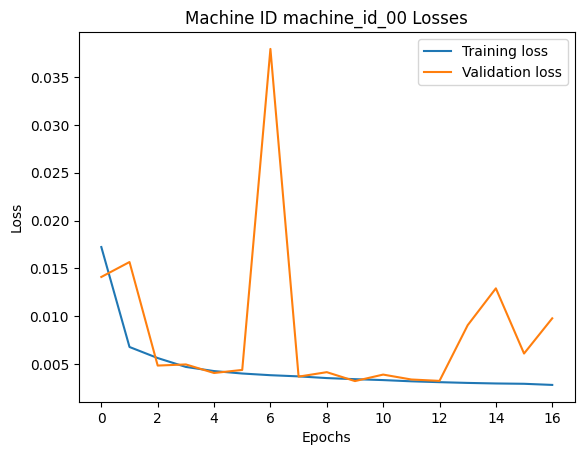

Validation Loss for Machine ID machine_id_00: Mean - 0.00854828663161207, Standard Deviation - 0.008348092202628627
Starting training for Machine ID machine_id_02


Epoch 1 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Epoch 1 Train loss: 0.0178, Val loss: 0.0123
Validation loss decreased (inf --> 0.012337).  Saving model ...


Epoch 2 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 2 Train loss: 0.0083, Val loss: 0.0060
Validation loss decreased (0.012337 --> 0.005966).  Saving model ...


Epoch 3 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


Epoch 3 Train loss: 0.0064, Val loss: 0.0044
Validation loss decreased (0.005966 --> 0.004407).  Saving model ...


Epoch 4 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


Epoch 4 Train loss: 0.0055, Val loss: 0.0040
Validation loss decreased (0.004407 --> 0.004034).  Saving model ...


Epoch 5 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


Epoch 5 Train loss: 0.0049, Val loss: 0.0041
EarlyStopping counter: 1 out of 7


Epoch 6 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Epoch 6 Train loss: 0.0045, Val loss: 0.0046
EarlyStopping counter: 2 out of 7


Epoch 7 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Epoch 7 Train loss: 0.0040, Val loss: 0.0045
EarlyStopping counter: 3 out of 7


Epoch 8 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


Epoch 8 Train loss: 0.0037, Val loss: 0.0039
Validation loss decreased (0.004034 --> 0.003924).  Saving model ...


Epoch 9 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Epoch 9 Train loss: 0.0035, Val loss: 0.0035
Validation loss decreased (0.003924 --> 0.003513).  Saving model ...


Epoch 10 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 10 Train loss: 0.0036, Val loss: 0.0039
EarlyStopping counter: 1 out of 7


Epoch 11 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 11 Train loss: 0.0034, Val loss: 0.0026
Validation loss decreased (0.003513 --> 0.002579).  Saving model ...


Epoch 12 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Epoch 12 Train loss: 0.0033, Val loss: 0.0027
EarlyStopping counter: 1 out of 7


Epoch 13 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.83s/it]


Epoch 13 Train loss: 0.0031, Val loss: 0.0024
Validation loss decreased (0.002579 --> 0.002388).  Saving model ...


Epoch 14 Validation: 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


Epoch 14 Train loss: 0.0030, Val loss: 0.0025
EarlyStopping counter: 1 out of 7


Epoch 15 Validation: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch 15 Train loss: 0.0031, Val loss: 0.0023
Validation loss decreased (0.002388 --> 0.002292).  Saving model ...


Epoch 16 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.33s/it]


Epoch 16 Train loss: 0.0029, Val loss: 0.0025
EarlyStopping counter: 1 out of 7


Epoch 17 Validation: 100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 17 Train loss: 0.0029, Val loss: 0.0027
EarlyStopping counter: 2 out of 7


Epoch 18 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 18 Train loss: 0.0029, Val loss: 0.0038
EarlyStopping counter: 3 out of 7


Epoch 19 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch 19 Train loss: 0.0029, Val loss: 0.0025
EarlyStopping counter: 4 out of 7


Epoch 20 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 20 Train loss: 0.0028, Val loss: 0.0071
EarlyStopping counter: 5 out of 7


Epoch 21 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Epoch 21 Train loss: 0.0028, Val loss: 0.0027
EarlyStopping counter: 6 out of 7


Epoch 22 Validation: 100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 22 Train loss: 0.0029, Val loss: 0.0029
EarlyStopping counter: 7 out of 7
Early stopping


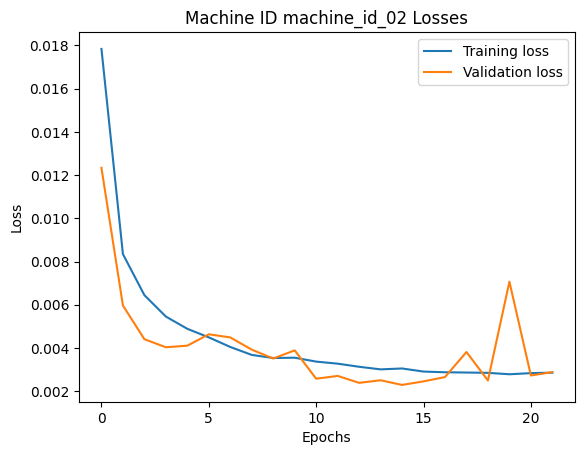

Validation Loss for Machine ID machine_id_02: Mean - 0.003994531273333864, Standard Deviation - 0.002180829094738874
Starting training for Machine ID machine_id_04


Epoch 1 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 1 Train loss: 0.0459, Val loss: 0.0295
Validation loss decreased (inf --> 0.029542).  Saving model ...


Epoch 2 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


Epoch 2 Train loss: 0.0314, Val loss: 0.0181
Validation loss decreased (0.029542 --> 0.018051).  Saving model ...


Epoch 3 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 3 Train loss: 0.0233, Val loss: 0.0161
Validation loss decreased (0.018051 --> 0.016060).  Saving model ...


Epoch 4 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch 4 Train loss: 0.0178, Val loss: 0.0201
EarlyStopping counter: 1 out of 7


Epoch 5 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Epoch 5 Train loss: 0.0134, Val loss: 0.0132
Validation loss decreased (0.016060 --> 0.013223).  Saving model ...


Epoch 6 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 6 Train loss: 0.0109, Val loss: 0.0094
Validation loss decreased (0.013223 --> 0.009413).  Saving model ...


Epoch 7 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 7 Train loss: 0.0087, Val loss: 0.0080
Validation loss decreased (0.009413 --> 0.007969).  Saving model ...


Epoch 8 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Epoch 8 Train loss: 0.0072, Val loss: 0.0076
Validation loss decreased (0.007969 --> 0.007646).  Saving model ...


Epoch 9 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 9 Train loss: 0.0059, Val loss: 0.0048
Validation loss decreased (0.007646 --> 0.004763).  Saving model ...


Epoch 10 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 10 Train loss: 0.0051, Val loss: 0.0039
Validation loss decreased (0.004763 --> 0.003859).  Saving model ...


Epoch 11 Validation: 100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 11 Train loss: 0.0046, Val loss: 0.0043
EarlyStopping counter: 1 out of 7


Epoch 12 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 12 Train loss: 0.0043, Val loss: 0.0030
Validation loss decreased (0.003859 --> 0.002996).  Saving model ...


Epoch 13 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 13 Train loss: 0.0041, Val loss: 0.0041
EarlyStopping counter: 1 out of 7


Epoch 14 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Epoch 14 Train loss: 0.0042, Val loss: 0.1687
EarlyStopping counter: 2 out of 7


Epoch 15 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 15 Train loss: 0.0039, Val loss: 0.0040
EarlyStopping counter: 3 out of 7


Epoch 16 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 16 Train loss: 0.0038, Val loss: 0.0024
Validation loss decreased (0.002996 --> 0.002395).  Saving model ...


Epoch 17 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 17 Train loss: 0.0037, Val loss: 0.0169
EarlyStopping counter: 1 out of 7


Epoch 18 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 18 Train loss: 0.0037, Val loss: 0.0035
EarlyStopping counter: 2 out of 7


Epoch 19 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 19 Train loss: 0.0035, Val loss: 0.0021
Validation loss decreased (0.002395 --> 0.002059).  Saving model ...


Epoch 20 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Epoch 20 Train loss: 0.0034, Val loss: 0.0023
EarlyStopping counter: 1 out of 7


Epoch 21 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 21 Train loss: 0.0034, Val loss: 0.0032
EarlyStopping counter: 2 out of 7


Epoch 22 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 22 Train loss: 0.0033, Val loss: 0.0025
EarlyStopping counter: 3 out of 7


Epoch 23 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Epoch 23 Train loss: 0.0033, Val loss: 0.0022
EarlyStopping counter: 4 out of 7


Epoch 24 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Epoch 24 Train loss: 0.0032, Val loss: 0.0023
EarlyStopping counter: 5 out of 7


Epoch 25 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 25 Train loss: 0.0032, Val loss: 0.0023
EarlyStopping counter: 6 out of 7


Epoch 26 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


Epoch 26 Train loss: 0.0031, Val loss: 0.0020
Validation loss decreased (0.002059 --> 0.001972).  Saving model ...


Epoch 27 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Epoch 27 Train loss: 0.0032, Val loss: 0.0024
EarlyStopping counter: 1 out of 7


Epoch 28 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 28 Train loss: 0.0030, Val loss: 0.0018
Validation loss decreased (0.001972 --> 0.001846).  Saving model ...


Epoch 29 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


Epoch 29 Train loss: 0.0030, Val loss: 0.0019
EarlyStopping counter: 1 out of 7


Epoch 30 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 30 Train loss: 0.0030, Val loss: 0.0018
Validation loss decreased (0.001846 --> 0.001773).  Saving model ...


Epoch 31 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


Epoch 31 Train loss: 0.0029, Val loss: 0.0020
EarlyStopping counter: 1 out of 7


Epoch 32 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 32 Train loss: 0.0029, Val loss: 0.0019
EarlyStopping counter: 2 out of 7


Epoch 33 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Epoch 33 Train loss: 0.0029, Val loss: 0.0020
EarlyStopping counter: 3 out of 7


Epoch 34 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.72s/it]


Epoch 34 Train loss: 0.0028, Val loss: 0.0018
EarlyStopping counter: 4 out of 7


Epoch 35 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 35 Train loss: 0.0028, Val loss: 0.0019
EarlyStopping counter: 5 out of 7


Epoch 36 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


Epoch 36 Train loss: 0.0028, Val loss: 0.0020
EarlyStopping counter: 6 out of 7


Epoch 37 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


Epoch 37 Train loss: 0.0028, Val loss: 0.0018
EarlyStopping counter: 7 out of 7
Early stopping


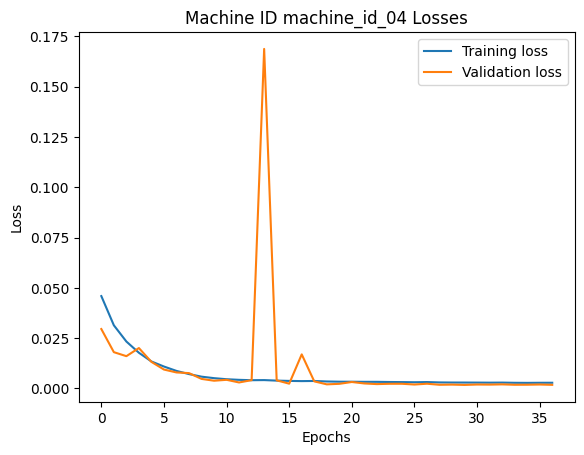

Validation Loss for Machine ID machine_id_04: Mean - 0.010217101823932885, Standard Deviation - 0.02718568618950082
Starting training for Machine ID machine_id_06


Epoch 1 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 1 Train loss: 0.0373, Val loss: 0.0248
Validation loss decreased (inf --> 0.024822).  Saving model ...


Epoch 2 Validation: 100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 2 Train loss: 0.0223, Val loss: 0.0138
Validation loss decreased (0.024822 --> 0.013802).  Saving model ...


Epoch 3 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Epoch 3 Train loss: 0.0161, Val loss: 0.0101
Validation loss decreased (0.013802 --> 0.010124).  Saving model ...


Epoch 4 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 4 Train loss: 0.0127, Val loss: 0.0108
EarlyStopping counter: 1 out of 7


Epoch 5 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 5 Train loss: 0.0107, Val loss: 0.0088
Validation loss decreased (0.010124 --> 0.008801).  Saving model ...


Epoch 6 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch 6 Train loss: 0.0093, Val loss: 0.0097
EarlyStopping counter: 1 out of 7


Epoch 7 Validation: 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


Epoch 7 Train loss: 0.0077, Val loss: 0.0066
Validation loss decreased (0.008801 --> 0.006600).  Saving model ...


Epoch 8 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 8 Train loss: 0.0062, Val loss: 0.0068
EarlyStopping counter: 1 out of 7


Epoch 9 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 9 Train loss: 0.0052, Val loss: 0.0050
Validation loss decreased (0.006600 --> 0.004964).  Saving model ...


Epoch 10 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Epoch 10 Train loss: 0.0051, Val loss: 0.0127
EarlyStopping counter: 1 out of 7


Epoch 11 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 11 Train loss: 0.0046, Val loss: 0.0032
Validation loss decreased (0.004964 --> 0.003201).  Saving model ...


Epoch 12 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


Epoch 12 Train loss: 0.0042, Val loss: 0.0036
EarlyStopping counter: 1 out of 7


Epoch 13 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 13 Train loss: 0.0038, Val loss: 0.0034
EarlyStopping counter: 2 out of 7


Epoch 14 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Epoch 14 Train loss: 0.0037, Val loss: 0.0035
EarlyStopping counter: 3 out of 7


Epoch 15 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Epoch 15 Train loss: 0.0036, Val loss: 0.0034
EarlyStopping counter: 4 out of 7


Epoch 16 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 16 Train loss: 0.0035, Val loss: 0.0028
Validation loss decreased (0.003201 --> 0.002767).  Saving model ...


Epoch 17 Validation: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 17 Train loss: 0.0034, Val loss: 0.0028
EarlyStopping counter: 1 out of 7


Epoch 18 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 18 Train loss: 0.0033, Val loss: 0.0032
EarlyStopping counter: 2 out of 7


Epoch 19 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


Epoch 19 Train loss: 0.0032, Val loss: 0.0026
Validation loss decreased (0.002767 --> 0.002562).  Saving model ...


Epoch 20 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 20 Train loss: 0.0031, Val loss: 0.0029
EarlyStopping counter: 1 out of 7


Epoch 21 Validation: 100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch 21 Train loss: 0.0031, Val loss: 0.0036
EarlyStopping counter: 2 out of 7


Epoch 22 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Epoch 22 Train loss: 0.0030, Val loss: 0.0032
EarlyStopping counter: 3 out of 7


Epoch 23 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 23 Train loss: 0.0030, Val loss: 0.0025
Validation loss decreased (0.002562 --> 0.002521).  Saving model ...


Epoch 24 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Epoch 24 Train loss: 0.0029, Val loss: 0.0023
Validation loss decreased (0.002521 --> 0.002285).  Saving model ...


Epoch 25 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


Epoch 25 Train loss: 0.0029, Val loss: 0.0362
EarlyStopping counter: 1 out of 7


Epoch 26 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Epoch 26 Train loss: 0.0028, Val loss: 0.0140
EarlyStopping counter: 2 out of 7


Epoch 27 Validation: 100%|██████████| 6/6 [00:11<00:00,  1.85s/it]


Epoch 27 Train loss: 0.0027, Val loss: 0.0027
EarlyStopping counter: 3 out of 7


Epoch 28 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.80s/it]


Epoch 28 Train loss: 0.0028, Val loss: 0.0021
Validation loss decreased (0.002285 --> 0.002141).  Saving model ...


Epoch 29 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 29 Train loss: 0.0028, Val loss: 0.0030
EarlyStopping counter: 1 out of 7


Epoch 30 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 30 Train loss: 0.0027, Val loss: 0.0025
EarlyStopping counter: 2 out of 7


Epoch 31 Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 31 Train loss: 0.0027, Val loss: 0.0023
EarlyStopping counter: 3 out of 7


Epoch 32 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 32 Train loss: 0.0026, Val loss: 0.0026
EarlyStopping counter: 4 out of 7


Epoch 33 Validation: 100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Epoch 33 Train loss: 0.0027, Val loss: 0.0022
EarlyStopping counter: 5 out of 7


Epoch 34 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


Epoch 34 Train loss: 0.0026, Val loss: 0.0035
EarlyStopping counter: 6 out of 7


Epoch 35 Validation: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]


Epoch 35 Train loss: 0.0025, Val loss: 0.0022
EarlyStopping counter: 7 out of 7
Early stopping


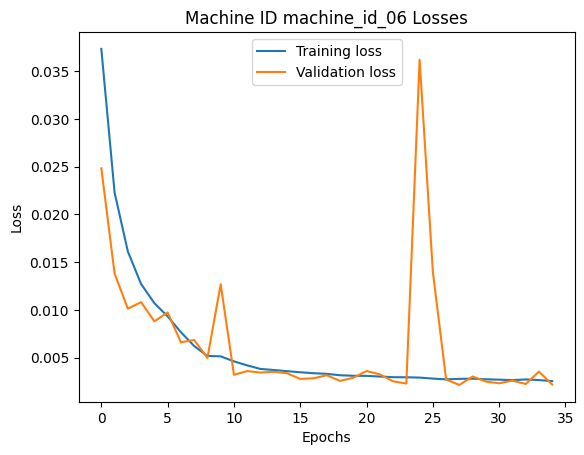

Validation Loss for Machine ID machine_id_06: Mean - 0.00644324429200164, Standard Deviation - 0.007013215145511093


In [ ]:
# # 모델 초기화 및 훈련 함수 호출
# models = {}
# for machine_id in machine_ids:
#     print(f'Starting training for Machine ID {machine_id}')
#     model = Autoencoder().to(device)  # 모델 인스턴스 생성
#     model = train_model(model, train_loader, val_loader, machine_id)
#     models[machine_id] = model  # 훈련된 모델 저장

In [ ]:
# import os
# import pickle

# results_dir = '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/results'

# # results 디렉토리가 없으면 생성
# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)

# for machine_id in machine_ids:
#     # 해당 machine_id의 train 데이터셋에서 min_val과 max_val 계산
#     train_files = [os.path.join(train_data_path, machine_id, 'train', file)
#                    for file in os.listdir(os.path.join(train_data_path, machine_id, 'train'))]
#     temp_dataset = AudioDataset(train_files)
#     min_val, max_val = temp_dataset.calculate_min_max_values()

#     # min_val과 max_val을 파일에 저장
#     min_max_file_path = os.path.join(results_dir, f'min_max_values_{machine_id}.pkl')
#     with open(min_max_file_path, 'wb') as f:
#         pickle.dump({'min_val': min_val, 'max_val': max_val}, f)


In [ ]:
#  Test code

In [ ]:
class Test_AudioDataset(Dataset):
    def __init__(self, file_paths, min_val=min_val, max_val=max_val, alpha=1.0, is_test=True):
        self.file_paths = file_paths
        self.min_val = min_val
        self.max_val = max_val
        self.alpha = alpha
        self.is_test = is_test  # 테스트 데이터셋인지 여부

        # min_val과 max_val이 제공되지 않았을 경우, 전체 데이터셋에서 계산
        # if self.min_val is None or self.max_val is None:
        #     self.min_val, self.max_val = self.calculate_min_max_values()


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        x = self.process_file(file_path)
        machine_id = file_path.split('/')[-3]

        # 테스트 데이터셋인 경우에만 라벨을 생성
        if self.is_test:
          label = 1 if 'anomaly' in file_path.split('/')[-1].split('_')[0] else 0
          return x, label, machine_id
        else:
          return x, machine_id


        # if self.is_test:
        #     label = 1 if 'anomaly' in file_path.split('/')[-1].split('_')[0] else 0
        #     return x, label
        # else:
        #     return x

    def process_file(self, file_path):
        # 오디오 파일 로드 및 스펙트로그램 생성
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)

        # 정규화
        normalized_log_S = (log_S - self.min_val) / (self.max_val - self.min_val)

        # PyTorch Tensor로 변환
        normalized_log_S_tensor = torch.tensor(normalized_log_S, dtype=torch.float32)
        return normalized_log_S_tensor




In [ ]:
len(test_files)

480

In [ ]:

test_data_path = '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/train/'

machine_ids = ['machine_id_00', 'machine_id_02', 'machine_id_04', 'machine_id_06']  # 사용할 모든 machine_id 리스트
test_files = []

for mid in machine_ids:
    # 경로를 올바르게 설정합니다.
    test_dir = os.path.join(test_data_path, mid, 'test')
    if os.path.isdir(test_dir):  # 디렉토리가 존재하는지 확인
        test_files.extend(
            [os.path.join(test_dir, file) for file in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, file))]
        )
    else:
        print(f"Directory not found: {test_dir}")


# 테스트 데이터셋 인스턴스 생성
test_dataset = Test_AudioDataset(file_paths=test_files, min_val=min_val, max_val=max_val)


# DataLoader 설정
batch_size = 4  # 필요에 따라 배치 크기 조정
shuffle = False  # 테스트 데이터셋에서는 일반적으로 셔플을 사용하지 않음

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)


In [ ]:
# 데이터셋 인스턴스 생성 예시
dataset = Test_AudioDataset(file_paths=test_files)

# 첫 번째 샘플 로드 및 검사
x, label, machine_id = dataset[0]
print(f"Machine ID: {machine_id}, Label: {label}")
print(x.shape)


Machine ID: machine_id_06, Label: 0
torch.Size([128, 313])


In [ ]:
model = Autoencoder()  # 예시 모델 구조
model_path = '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00.pt'  # 예시 파일 경로
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
import os

# 해당 디렉토리의 파일 목록을 출력합니다.
print(os.listdir('/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/train'))


['machine_id_00', 'machine_id_02', 'machine_id_04', 'machine_id_06']


In [ ]:
# 전체 경로와 함께 파일 및 디렉토리 목록을 출력합니다.
directory_path = '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan'
files_and_directories = [os.path.join(directory_path, f) for f in os.listdir(directory_path)]

print(files_and_directories, sep='\n')


['/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/test', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/train', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/backup', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00_fold_1.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_02.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_04.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/results', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_06.pt']


In [ ]:
# 파일 목록에서 실제 파일만 필터링합니다.
files = [f for f in files_and_directories if os.path.isfile(f)]

print(files)


['/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00_fold_1.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_02.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_04.pt', '/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_06.pt']


In [ ]:
!ls -l "/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/train"


total 16
drwx------ 4 root root 4096 Dec  6 02:27 machine_id_00
drwx------ 4 root root 4096 Dec  6 02:27 machine_id_02
drwx------ 4 root root 4096 Dec  6 02:27 machine_id_04
drwx------ 4 root root 4096 Dec  6 02:27 machine_id_06


In [ ]:
machine_id_metrics = {}
for machine_id in machine_ids:
    # 모델 인스턴스 생성 및 파라미터 로드
    model = Autoencoder()
    model_path = f'/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00.pt'
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

In [ ]:
machine_id_loss_stats = {'machine_id_00':(0.0085482866316120,0.008348092202628627),
                         'machine_id_02':( 0.003994531273333864, 0.002180829094738874),
                         'machine_id_04':(0.010217101823932885,0.02718568618950082 ),
                         'machine_id_06':(0.00644324429200164,0.007013215145511093 )}

# 임계값 계산 로직을 machine_id별로 처리
def calculate_thresholds(machine_id_loss_stats):
    thresholds = {}
    for machine_id, stats in machine_id_loss_stats.items():
        val_loss_mean, val_loss_std = stats
        thresholds[machine_id] = val_loss_mean + 2 * val_loss_std
    return thresholds

In [ ]:
thresholds = calculate_thresholds(machine_id_loss_stats)
print(thresholds)

{'machine_id_00': 0.025244471036869255, 'machine_id_02': 0.008356189462811612, 'machine_id_04': 0.06458847420293452, 'machine_id_06': 0.020469674583023827}


In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, auc

# # machine_id별로 val_loss_mean, val_loss_std 계산 (예시)

# machine_id_loss_stats = {'machine_id_00':(0.0085482866316120,0.008348092202628627),
#                          'machine_id_02':( 0.003994531273333864, 0.002180829094738874),
#                          'machine_id_04':(0.010217101823932885,0.02718568618950082 ),
#                          'machine_id_06':(0.00644324429200164,0.007013215145511093 )}

# # 임계값 계산 로직을 machine_id별로 처리
# def calculate_thresholds(machine_id_loss_stats):
#     thresholds = {}
#     for machine_id, stats in machine_id_loss_stats.items():
#         val_loss_mean, val_loss_std = stats
#         thresholds[machine_id] = val_loss_mean + 3 * val_loss_std
#     return thresholds



def calculate_prauc(y_true, y_scores):
    """
    PR AUC를 계산하는 함수입니다.
    :param y_true: 실제 라벨의 리스트
    :param y_scores: 모델이 예측한 점수의 리스트
    :return: PR AUC 값
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    return pr_auc



# 성능 평가 함수
def evaluate_model(model, loader, thresholds):
    results = {machine_id: {'y_true': [], 'y_scores': [], 'y_pred': []} for machine_id in thresholds.keys()}

    with torch.no_grad():
        for data in loader:
            mixed_x, label, machine_ids = data
            mixed_x = mixed_x.to(device)  # 전체 배치를 한 번에 장치로 이동

            for i in range(len(mixed_x)):
                single_x = mixed_x[i]
                if single_x.dim() == 2:
                    single_x = single_x.unsqueeze(0).unsqueeze(0)
                single_x = single_x.to(device)
                # print("mixed_x의 모양:", mixed_x.shape)

                  # 배치 차원 추가
                single_label = label[i]
                machine_id = machine_ids[i]
                # print(f"Current machine_id: {machine_id}")  # 디버그 출력
                threshold = thresholds[machine_id]

                output = model(single_x)
                loss = torch.nn.functional.mse_loss(output, single_x, reduction='none')
                loss = loss.mean().item()  # 항목으로 변환

                results[machine_id]['y_true'].append(single_label.cpu().item())
                results[machine_id]['y_scores'].append(loss)
                results[machine_id]['y_pred'].append(1 if loss > threshold else 0)

    # 각 machine_id별로 성능 지표 계산
    machine_id_metrics = {}
    for machine_id, data in results.items():
        if len(data['y_true']) > 0 and len(data['y_pred']) > 0:  # 데이터가 있는 경우에만 계산
            precision, recall, f1, _ = precision_recall_fscore_support(
                data['y_true'], data['y_pred'], average='binary', zero_division=1)
            auc_score = roc_auc_score(data['y_true'], data['y_scores'])
            pr_auc = calculate_prauc(data['y_true'], data['y_scores'])

            machine_id_metrics[machine_id] = {
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc_score,
            'pAUC': pr_auc  # 추가된 부분
        }
        else:
            print(f"No data for machine ID {machine_id}. Skipping...")
            machine_id_metrics[machine_id] = {
                'Precision': None, 'Recall': None, 'F1 Score': None, 'AUC': None
            }

    return machine_id_metrics

# 성능 평가 및 결과 출력
machine_id_metrics = evaluate_model(model, test_loader, thresholds)
for machine_id, metrics in machine_id_metrics.items():
    print(f"Machine ID: {machine_id}, Metrics: {metrics}")


Machine ID: machine_id_00, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.5325, 'PR AUC': 0.1880434935213059}
Machine ID: machine_id_02, Metrics: {'Precision': 0.25, 'Recall': 0.3, 'F1 Score': 0.2727272727272727, 'AUC': 0.649, 'PR AUC': 0.3348459439074656}
Machine ID: machine_id_04, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.48749999999999993, 'PR AUC': 0.15656991735528286}
Machine ID: machine_id_06, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.611, 'PR AUC': 0.19733780475926774}


In [ ]:
test_loader

In [ ]:
test_files =

In [ ]:
test_dataset = Test_AudioDataset(file_paths=test_files, min_val=min_val, max_val=max_val)


# DataLoader 설정
batch_size = 4  # 필요에 따라 배치 크기 조정
shuffle = False  # 테스트 데이터셋에서는 일반적으로 셔플을 사용하지 않음

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, auc

# # machine_id별로 val_loss_mean, val_loss_std 계산 (예시)

# machine_id_loss_stats = {'machine_id_00':(0.0085482866316120,0.008348092202628627),
#                          'machine_id_02':( 0.003994531273333864, 0.002180829094738874),
#                          'machine_id_04':(0.010217101823932885,0.02718568618950082 ),
#                          'machine_id_06':(0.00644324429200164,0.007013215145511093 )}

# # 임계값 계산 로직을 machine_id별로 처리
# def calculate_thresholds(machine_id_loss_stats):
#     thresholds = {}
#     for machine_id, stats in machine_id_loss_stats.items():
#         val_loss_mean, val_loss_std = stats
#         thresholds[machine_id] = val_loss_mean + 3 * val_loss_std
#     return thresholds



from sklearn.metrics import roc_curve, auc

def calculate_pauc(y_true, y_scores, max_fpr):
    """
    pAUC를 계산하는 함수입니다.
    :param y_true: 실제 라벨의 리스트
    :param y_scores: 모델이 예측한 점수의 리스트
    :param max_fpr: 계산할 최대 FPR 값
    :return: pAUC 값
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    stop_index = np.where(fpr <= max_fpr)[0][-1]
    pAUC = auc(fpr[:stop_index + 1], tpr[:stop_index + 1])
    return pAUC


# 성능 평가 함수
def evaluate_model(model, loader, thresholds):
    results = {machine_id: {'y_true': [], 'y_scores': [], 'y_pred': []} for machine_id in thresholds.keys()}

    with torch.no_grad():
        for data in loader:
            mixed_x, label, machine_ids = data
            mixed_x = mixed_x.to(device)  # 전체 배치를 한 번에 장치로 이동

            for i in range(len(mixed_x)):
                single_x = mixed_x[i]
                if single_x.dim() == 2:
                    single_x = single_x.unsqueeze(0).unsqueeze(0)
                single_x = single_x.to(device)
                # print("mixed_x의 모양:", mixed_x.shape)

                  # 배치 차원 추가
                single_label = label[i]
                machine_id = machine_ids[i]
                # print(f"Current machine_id: {machine_id}")  # 디버그 출력
                threshold = thresholds[machine_id]

                output = model(single_x)
                loss = torch.nn.functional.mse_loss(output, single_x, reduction='none')
                loss = loss.mean().item()  # 항목으로 변환

                results[machine_id]['y_true'].append(single_label.cpu().item())
                results[machine_id]['y_scores'].append(loss)
                results[machine_id]['y_pred'].append(1 if loss > threshold else 0)

    # 각 machine_id별로 성능 지표 계산
    machine_id_metrics = {}
    for machine_id, data in results.items():
        if len(data['y_true']) > 0 and len(data['y_pred']) > 0:  # 데이터가 있는 경우에만 계산
            precision, recall, f1, _ = precision_recall_fscore_support(
                data['y_true'], data['y_pred'], average='binary', zero_division=1)
            auc_score = roc_auc_score(data['y_true'], data['y_scores'])
            max_fpr_value = 0.1  # 원하는 최대 FPR 값 설정
            pauc = calculate_pauc(data['y_true'], data['y_scores'], max_fpr_value)

            # print("Calculated pAUC:", pauc)

            machine_id_metrics[machine_id] = {
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc_score,
            'pAUC': pauc  # 추가된 부분
        }
        else:
            print(f"No data for machine ID {machine_id}. Skipping...")
            machine_id_metrics[machine_id] = {
                'Precision': None, 'Recall': None, 'F1 Score': None, 'AUC': None
            }

    return machine_id_metrics

In [ ]:
from glob import glob

In [ ]:
test_files = sorted(glob("/content/drive/MyDrive/Capstone_Project/DCASE_challenge/fan/test/*.wav"))

In [ ]:
test_dataset = Test_AudioDataset(file_paths=test_files, min_val=min_val, max_val=max_val)


# DataLoader 설정
batch_size = 4  # 필요에 따라 배치 크기 조정
shuffle = False  # 테스트 데이터셋에서는 일반적으로 셔플을 사용하지 않음

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
thresholds

{'machine_id_00': 0.025244471036869255,
 'machine_id_02': 0.008356189462811612,
 'machine_id_04': 0.06458847420293452,
 'machine_id_06': 0.020469674583023827}

In [ ]:
class Test_AudioDataset(Dataset):
    def __init__(self, file_paths, min_val=min_val, max_val=max_val, alpha=1.0, is_test=True):
        self.file_paths = file_paths
        self.min_val = min_val
        self.max_val = max_val
        self.alpha = alpha
        self.is_test = is_test  # 테스트 데이터셋인지 여부

        # min_val과 max_val이 제공되지 않았을 경우, 전체 데이터셋에서 계산
        # if self.min_val is None or self.max_val is None:
        #     self.min_val, self.max_val = self.calculate_min_max_values()


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        x = self.process_file(file_path)

        if self.is_test:
          id = file_path.split('/')[-1].split('_')[2]
          machine_id = f'machine_id_{id}'
        else:
          machine_id = file_path.split('/')[-3]

        # 테스트 데이터셋인 경우에만 라벨을 생성
        if self.is_test:
          label = 1 if 'anomaly' in file_path.split('/')[-1].split('_')[0] else 0
          return x, label, machine_id
        else:
          return x, machine_id


        # if self.is_test:
        #     label = 1 if 'anomaly' in file_path.split('/')[-1].split('_')[0] else 0
        #     return x, label
        # else:
        #     return x

    def process_file(self, file_path):
        # 오디오 파일 로드 및 스펙트로그램 생성
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)

        # 정규화
        normalized_log_S = (log_S - self.min_val) / (self.max_val - self.min_val)

        # PyTorch Tensor로 변환
        normalized_log_S_tensor = torch.tensor(normalized_log_S, dtype=torch.float32)
        return normalized_log_S_tensor




In [ ]:
test_files[0].split('/')[-1].split('_')[2]

'00'

In [ ]:
thresholds

{'machine_id_00': 0.025244471036869255,
 'machine_id_02': 0.008356189462811612,
 'machine_id_04': 0.06458847420293452,
 'machine_id_06': 0.020469674583023827}

In [ ]:
machine_ids = ['machine_id_00', 'machine_id_02', 'machine_id_04', 'machine_id_06']

for machine_id in machine_ids:
    # 모델 인스턴스 생성 및 파라미터 로드
    model = Autoencoder()
    model_path = f'/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_{machine_id}.pt'
    print(model_path)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    machine_id_metrics = evaluate_model(model, test_loader, thresholds)
    for machine_id, metrics in machine_id_metrics.items():
        print(f"Machine ID: {machine_id}, Metrics: {metrics}")

    print('='*50)

/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_00.pt
Machine ID: machine_id_00, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.482014742014742, 'pAUC': 0.004324324324324325}
Machine ID: machine_id_02, Metrics: {'Precision': 0.8285714285714286, 'Recall': 0.24233983286908078, 'F1 Score': 0.375, 'AUC': 0.5145682451253482, 'pAUC': 0.0083008356545961}
Machine ID: machine_id_04, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.5176724137931035, 'pAUC': 0.0017241379310344832}
Machine ID: machine_id_06, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.5884764542936288, 'pAUC': 0.0037119113573407204}
/content/drive/My Drive/Capstone_Project/DCASE_challenge/fan/model_machine_id_02.pt
Machine ID: machine_id_00, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.5452088452088452, 'pAUC': 0.005380835380835381}
Machine ID: machine_id_02, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score'

In [ ]:
machine_id_metrics = evaluate_model(model, test_loader, thresholds)
for machine_id, metrics in machine_id_metrics.items():
    print(f"Machine ID: {machine_id}, Metrics: {metrics}")

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, auc

# # machine_id별로 val_loss_mean, val_loss_std 계산 (예시)

# machine_id_loss_stats = {'machine_id_00':(0.0085482866316120,0.008348092202628627),
#                          'machine_id_02':( 0.003994531273333864, 0.002180829094738874),
#                          'machine_id_04':(0.010217101823932885,0.02718568618950082 ),
#                          'machine_id_06':(0.00644324429200164,0.007013215145511093 )}

# # 임계값 계산 로직을 machine_id별로 처리
# def calculate_thresholds(machine_id_loss_stats):
#     thresholds = {}
#     for machine_id, stats in machine_id_loss_stats.items():
#         val_loss_mean, val_loss_std = stats
#         thresholds[machine_id] = val_loss_mean + 3 * val_loss_std
#     return thresholds



def calculate_prauc(y_true, y_scores):
    """
    PR AUC를 계산하는 함수입니다.
    :param y_true: 실제 라벨의 리스트
    :param y_scores: 모델이 예측한 점수의 리스트
    :return: PR AUC 값
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    return pr_auc



# 성능 평가 함수
def evaluate_model(model_list, loader, thresholds):
    results = {machine_id: {'y_true': [], 'y_scores': [], 'y_pred': []} for machine_id in thresholds.keys()}


    for model_path in model_list:
      model = Autoencoder()
      model.load_state_dict(torch.load(model_path))

      with torch.no_grad():
          for data in loader:
              mixed_x, label, machine_ids = data
              mixed_x = mixed_x.to(device)  # 전체 배치를 한 번에 장치로 이동

              for i in range(len(mixed_x)):
                  single_x = mixed_x[i]
                  if single_x.dim() == 2:
                      single_x = single_x.unsqueeze(0).unsqueeze(0)
                  single_x = single_x.to(device)
                  # print("mixed_x의 모양:", mixed_x.shape)

                    # 배치 차원 추가
                  single_label = label[i]
                  machine_id = machine_ids[i]
                  # print(f"Current machine_id: {machine_id}")  # 디버그 출력
                  threshold = thresholds[machine_id]

                  output = model(single_x)
                  loss = torch.nn.functional.mse_loss(output, single_x, reduction='none')
                  loss = loss.mean().item()  # 항목으로 변환

                  results[machine_id]['y_true'].append(single_label.cpu().item())
                  results[machine_id]['y_scores'].append(loss)
                  results[machine_id]['y_pred'].append(1 if loss > threshold else 0)

      # 각 machine_id별로 성능 지표 계산
      machine_id_metrics = {}
      for machine_id, data in results.items():
          if len(data['y_true']) > 0 and len(data['y_pred']) > 0:  # 데이터가 있는 경우에만 계산
              precision, recall, f1, _ = precision_recall_fscore_support(
                  data['y_true'], data['y_pred'], average='binary', zero_division=1)
              auc_score = roc_auc_score(data['y_true'], data['y_scores'])
              pr_auc = calculate_prauc(data['y_true'], data['y_scores'])

              machine_id_metrics[machine_id] = {
              'Precision': precision,
              'Recall': recall,
              'F1 Score': f1,
              'AUC': auc_score,
              'PR AUC': pr_auc  # 추가된 부분
          }
          else:
              print(f"No data for machine ID {machine_id}. Skipping...")
              machine_id_metrics[machine_id] = {
                  'Precision': None, 'Recall': None, 'F1 Score': None, 'AUC': None
              }

      return machine_id_metrics

# 성능 평가 및 결과 출력

machine_id_metrics = evaluate_model(model, test_loader, thresholds)
for machine_id, metrics in machine_id_metrics.items():
    print(f"Machine ID: {machine_id}, Metrics: {metrics}")


3시그마

Machine ID: machine_id_00, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.5325, 'PR AUC': 0.1880434935213059}
Machine ID: machine_id_02, Metrics: {'Precision': 0.36363636363636365, 'Recall': 0.2, 'F1 Score': 0.25806451612903225, 'AUC': 0.649, 'PR AUC': 0.3348459439074656}
Machine ID: machine_id_04, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.48749999999999993, 'PR AUC': 0.15656991735528286}
Machine ID: machine_id_06, Metrics: {'Precision': 1.0, 'Recall': 0.0, 'F1 Score': 0.0, 'AUC': 0.611, 'PR AUC': 0.19733780475926774}